In [1]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Layer
import tensorflow_addons as tfa

import numpy as np
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

AUTOTUNE = tf.data.experimental.AUTOTUNE


2023-11-24 12:09:57.959261: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-24 12:09:57.981877: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-24 12:09:57.981897: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-24 12:09:57.981914: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-24 12:09:57.986499: I tensorflow/core/platform/cpu_feature_g

In [4]:
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.14.0'

## Labels (Photo, Monet)

In [2]:
# Define the labels
LABELS_PHOTO = [
    [2],                     # sky
    [21, 26, 60, 109, 113],  # water
    [4, 9, 17, 29, 66]       # vegetation
]

LABELS_MONET = [
    [3],  # sky
    [22,27,61],  # water
    [5,10,18]   # vegetation
]

# number of segmentation channels between photos and monet pictures have to match
assert len(LABELS_PHOTO) == len(LABELS_MONET)


In [3]:
BUFFER_SIZE = 1000
BATCH_SIZE = 16
EPOCHS_NUM = 5
IMG_WIDTH = 256
IMG_HEIGHT = 256

NUM_SEG_CHANNELS = len(LABELS_PHOTO)
NUM_RGB_CHANNELS = 3
NUM_CHANNELS = NUM_RGB_CHANNELS + NUM_SEG_CHANNELS


## Photo-Monet dataset

In [4]:
PHOTO_IMAGES_PATH = './photo_jpg/'
PHOTO_SEGMNT_PATH = './photo_segmented_numpy/'

MONET_IMAGES_PATH = './BobRoss/train/images/'
MONET_SEGMNT_PATH = './BobRoss/train/labels_npy/'


In [5]:
# Function to get corresponding segmentation file path for a given image file path
def get_segmentation_path(dir_path, image_file):
    basename = os.path.basename(image_file)
    segmentation_filename = os.path.splitext(basename)[0] + ".npy"
    return os.path.join(dir_path, segmentation_filename)


################# PHOTO #################
photo_image_files = sorted(glob.glob(PHOTO_IMAGES_PATH + '*.jpg'))
photo_segmentation_files = [get_segmentation_path(PHOTO_SEGMNT_PATH, img_file) for img_file in photo_image_files]

# Ensure you have the same number of images and segmentation masks
assert len(photo_image_files) == len(photo_segmentation_files), "Mismatched image and mask counts"
print('Number of Photo images:', len(photo_image_files))


################# MONET #################
monet_image_files = sorted(glob.glob(MONET_IMAGES_PATH + '*.png'))
monet_segmentation_files = [get_segmentation_path(MONET_SEGMNT_PATH, img_file) for img_file in monet_image_files]

# Ensure you have the same number of images and segmentation masks
assert len(monet_image_files) == len(monet_segmentation_files), "Mismatched image and mask counts"
print('Number of Monet images:', len(monet_image_files))


Number of Photo images: 7038
Number of Monet images: 250


#### Helper functions for creating and appending binary segmentation masks to RGB

In [6]:
def load_npy_file(path):
    array = np.load(path.numpy().decode('utf-8'))
    return tf.convert_to_tensor(array, dtype=tf.int8)


# Function to create binary masks from segmentation labels
def create_binary_masks(segmentation, labels):
    # Cast segmentation to int32 to match the labels' dtype
    segmentation = tf.cast(segmentation, tf.int32)

    # Initialize an empty list to store the masks
    masks = []

    for label_group in labels:
        # Initialize the mask to False for each label group
        mask = tf.zeros_like(segmentation, dtype=tf.bool)

        # Logical OR to combine all labels in the group
        for label in label_group:
            mask = tf.logical_or(mask, tf.equal(segmentation, label))

        # Cast the boolean mask to float and append to the list
        masks.append(tf.cast(mask, tf.float32))

    # Stack along the last dimension to create a multi-channel mask
    binary_masks = tf.stack(masks, axis=-1)

    return binary_masks


# Function to load and preprocess the image and segmentation files
def load_and_preprocess(image_file, segmentation_file, labels):

    # Load the image
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 127.5 - 1

    # Load the segmentation mask using tf.py_function (to handle numpy operation)
    segmentation = tf.py_function(load_npy_file, [segmentation_file], tf.int8)
    segmentation = tf.cast(segmentation, tf.float32)  # Convert to float without normalizing
    segmentation = tf.reshape(segmentation, [IMG_HEIGHT, IMG_WIDTH])

    # Create binary masks from the segmentation mask
    binary_masks = create_binary_masks(segmentation, labels)

    # Concatenate the image and the binary masks
    combined = tf.concat([image, binary_masks], axis=-1)

    return combined


def wrapper_load_and_preprocess(labels):
    def inner_function(image_file, segmentation_file):
        return load_and_preprocess(image_file, segmentation_file, labels)
    return inner_function



#### Data Augmentation

In [7]:
def data_augment(image):
    num_channels = image.shape[-1]

    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    # Apply jitter
    if p_crop > .5:
        image = tf.image.resize(image, [286, 286])
        image = tf.image.random_crop(image, size=[256, 256, num_channels])
        if p_crop > .9:
            image = tf.image.resize(image, [300, 300])
            image = tf.image.random_crop(image, size=[256, 256, num_channels])

    # Random rotation
#     if p_rotate > .5:
#         image = tf.image.flip_left_right(image)
#         image = tf.image.rot90(image, k=3) # rotate 270º
#     elif p_rotate > .7:
#         image = tf.image.rot90(image, k=2) # rotate 180º
#     elif p_rotate > .5:
#         image = tf.image.rot90(image, k=1) # rotate 90º

#     # Random mirroring
    if p_spatial > .6:
        image = tf.image.random_flip_left_right(image)
#        image = tf.image.random_flip_up_down(image)
#         if p_spatial > .9:
#             image = tf.image.transpose(image)

    return image


In [8]:
photo_ds = tf.data.Dataset.from_tensor_slices((photo_image_files, photo_segmentation_files))
photo_ds = photo_ds.map(wrapper_load_and_preprocess(LABELS_PHOTO))
photo_ds = photo_ds.batch(1, drop_remainder=True)

monet_ds = tf.data.Dataset.from_tensor_slices((monet_image_files, monet_segmentation_files))
monet_ds = monet_ds.map(wrapper_load_and_preprocess(LABELS_MONET))
monet_ds = monet_ds.batch(1, drop_remainder=True)


2023-11-24 12:10:16.599058: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-24 12:10:16.599077: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: siamac2
2023-11-24 12:10:16.599079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: siamac2
2023-11-24 12:10:16.599117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.129.3
2023-11-24 12:10:16.599127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.129.3
2023-11-24 12:10:16.599129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.129.3


In [9]:
def get_gan_dataset(photo_image_files, photo_segmentation_files,
                    monet_image_files, monet_segmentation_files,
                    augment=None, repeat=True, shuffle=True, batch_size=1):

    photo_ds = tf.data.Dataset.from_tensor_slices((photo_image_files, photo_segmentation_files))
    photo_ds = photo_ds.map(wrapper_load_and_preprocess(LABELS_PHOTO))

    monet_ds = tf.data.Dataset.from_tensor_slices((monet_image_files, monet_segmentation_files))
    monet_ds = monet_ds.map(wrapper_load_and_preprocess(LABELS_MONET))

    if augment:
        monet_ds = monet_ds.map(augment, num_parallel_calls=AUTOTUNE)
        photo_ds = photo_ds.map(augment, num_parallel_calls=AUTOTUNE)

    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()

    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)

    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    # monet_ds = monet_ds.cache()
    # photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(AUTOTUNE)
    photo_ds = photo_ds.prefetch(AUTOTUNE)

    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))

    return gan_ds

full_dataset = get_gan_dataset(photo_image_files=photo_image_files,
                               photo_segmentation_files=photo_segmentation_files,
                               monet_image_files=monet_image_files,
                               monet_segmentation_files=monet_segmentation_files,
                               augment=data_augment,
                               repeat=True,
                               shuffle=True,
                               batch_size=BATCH_SIZE)


In [10]:
example_monet_batch, example_photo_batch = next(iter(full_dataset))

assert example_photo_batch.shape == example_monet_batch.shape
print(example_photo_batch.shape)

(16, 256, 256, 6)


In [11]:
def visualize_images_and_masks(batch):
    # Number of segmentation channels (assuming they are the last channels)
    num_segmentation_channels = batch.shape[-1] - 3

    # Determine the number of rows needed in the subplot
    num_rows = num_segmentation_channels + 1

    # Create a subplot with appropriate size
    fig, axes = plt.subplots(num_rows, batch.shape[0], figsize=(15, 2 * num_rows))

    for i in range(batch.shape[0]):
        # Extract the RGB image and segmentation masks from the batch
        image = batch[i, ..., :3]
        masks = [batch[i, ..., j] for j in range(3, 3 + num_segmentation_channels)]

        # Display the RGB image
        axes[0, i].imshow(tf.keras.preprocessing.image.array_to_img(image))
        axes[0, i].axis('off')

        # Display each segmentation mask
        for j, mask in enumerate(masks, 1):
            axes[j, i].imshow(mask, cmap='gray')
            axes[j, i].axis('off')

    plt.tight_layout()
    plt.show()


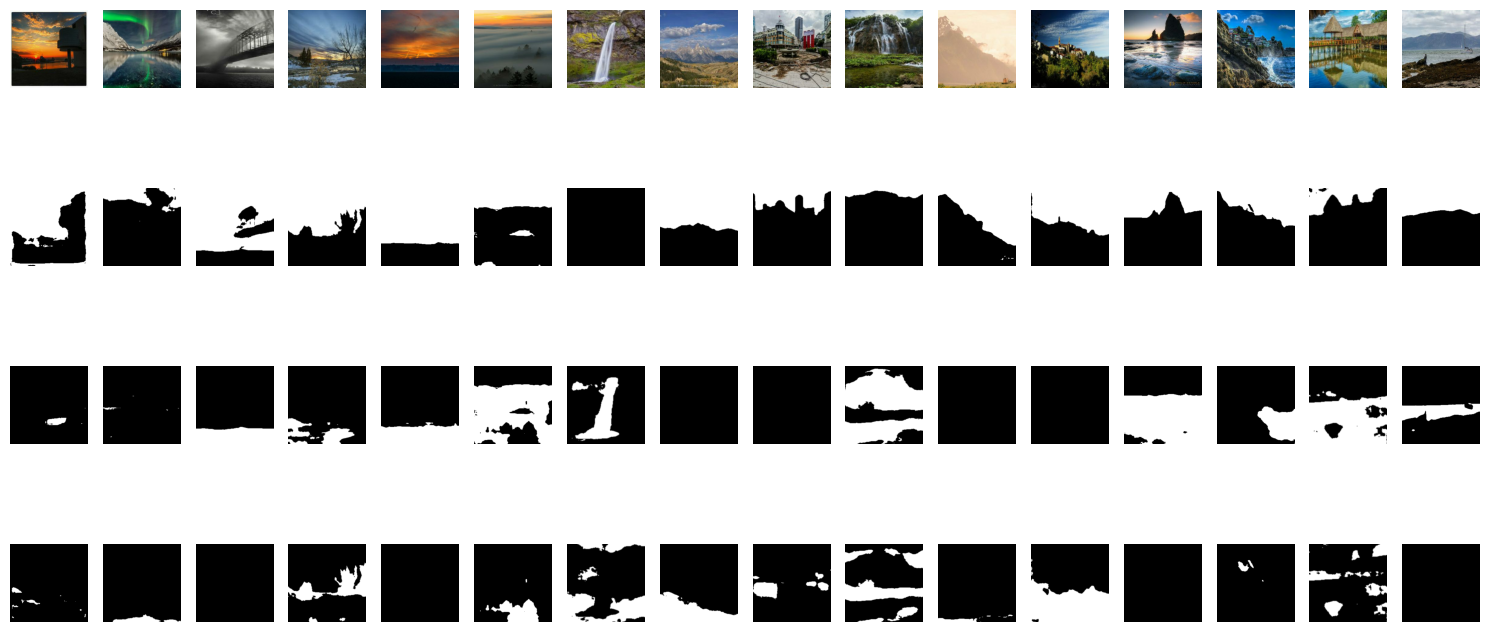

In [12]:
visualize_images_and_masks(example_photo_batch)

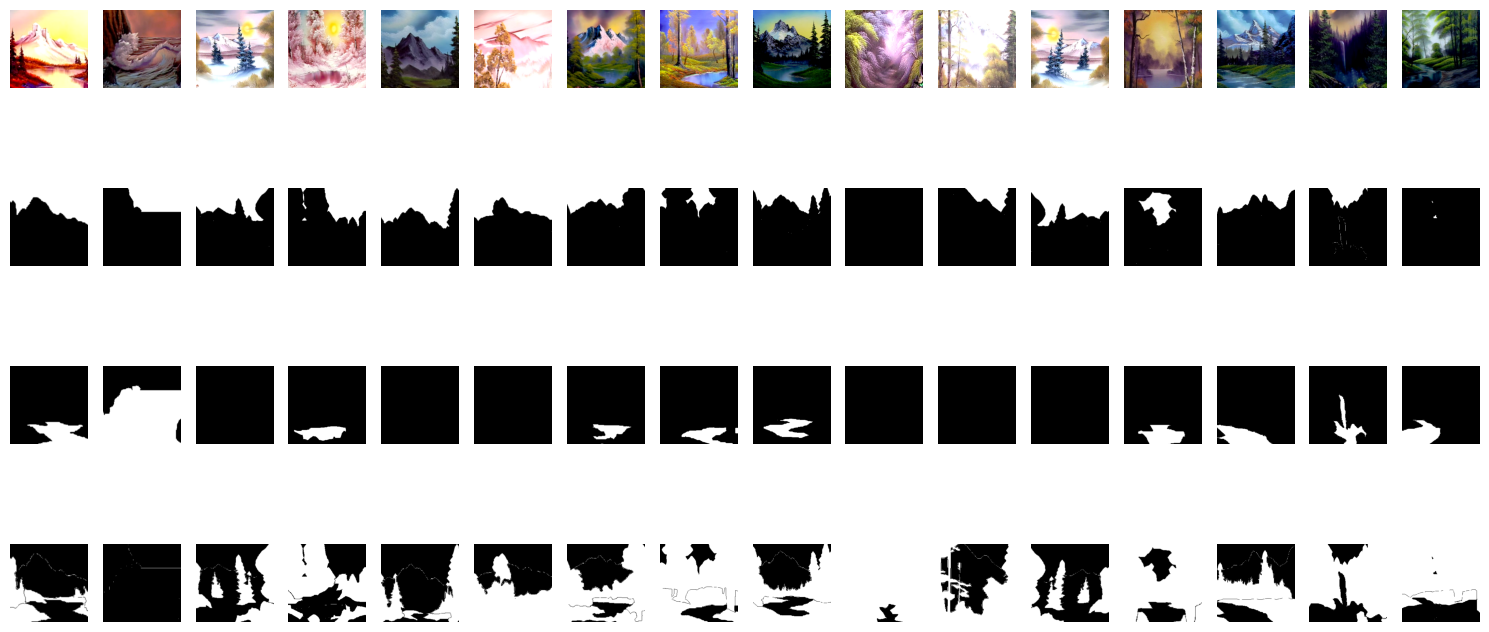

In [14]:
visualize_images_and_masks(example_monet_batch)

## Model

In [13]:
OUTPUT_CHANNELS = NUM_CHANNELS

class SelectiveInstanceNormalization(Layer):
    def __init__(self, **kwargs):
        super(SelectiveInstanceNormalization, self).__init__(**kwargs)
        self.instancenorm = tfa.layers.InstanceNormalization()

    def call(self, inputs):
        # Split the tensor into RGB and segmentation channels
        rgb = inputs[..., :3]
        seg = inputs[..., 3:]

        # Apply instance normalization only to the RGB channels
        rgb_normalized = self.instancenorm(rgb)

        # Concatenate the normalized RGB channels with the untouched segmentation channels
        return tf.concat([rgb_normalized, seg], axis=-1)


def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        # Add the custom normalization layer to the sequential model
        result.add(SelectiveInstanceNormalization())

    result.add(layers.LeakyReLU())

    return result



In [14]:
class SelectiveDropout(Layer):
    def __init__(self, rate, **kwargs):
        super(SelectiveDropout, self).__init__(**kwargs)
        self.rate = rate
        self.dropout = layers.Dropout(rate)

    def call(self, inputs, training=None):
        # Split the tensor into RGB and segmentation channels
        rgb = inputs[..., :3]
        seg = inputs[..., 3:]

        # Apply dropout only to the RGB channels
        rgb_dropped = self.dropout(rgb, training=training)

        # Concatenate the dropout RGB channels with the untouched segmentation channels
        return tf.concat([rgb_dropped, seg], axis=-1)


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    # Add the custom SelectiveInstanceNormalization layer
    result.add(SelectiveInstanceNormalization())

    if apply_dropout:
        # Add the custom SelectiveDropout layer
        result.add(SelectiveDropout(rate=0.5))

    result.add(layers.ReLU())

    return result


In [15]:
class CustomOutputProcessing(Layer):
    def __init__(self, num_rgb_channels=3, **kwargs):
        super(CustomOutputProcessing, self).__init__(**kwargs)
        self.num_rgb_channels = num_rgb_channels

    def call(self, inputs):
        # Split the tensor into RGB and segmentation channels
        rgb = inputs[..., :self.num_rgb_channels]
        seg = inputs[..., self.num_rgb_channels:]

        # Apply tanh to RGB channels for the Monet-style image
        rgb = tf.keras.activations.tanh(rgb)

        # Apply sigmoid to segmentation channels for binary masks
        seg = tf.keras.activations.sigmoid(seg)

        # Concatenate the processed RGB and segmentation channels
        return tf.concat([rgb, seg], axis=-1)


def Generator():
    inputs = layers.Input(shape=[256, 256, NUM_CHANNELS])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)

    # The last layer before applying custom processing for the output
    last = layers.Conv2DTranspose(NUM_CHANNELS, 4, strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation=None)  # No activation here

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    # Apply the processing using the CustomOutputProcessing layer
    x = CustomOutputProcessing(num_rgb_channels=3)(x)

    return keras.Model(inputs=inputs, outputs=x)


In [16]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    # Adjust the input shape to take 6-channel images (RGB + segmentation)
    inp = layers.Input(shape=[256, 256, NUM_CHANNELS], name='input_image')

    x = inp

    # The rest of the architecture remains the same, it will automatically
    # adjust to the increased depth due to the change in input shape
    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    # The output layer remains the same as it is a scalar output (single channel)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)


In [17]:
monet_generator = Generator() # transforms photos to Monet-esque paintings
photo_generator = Generator() # transforms Monet paintings to be more like photos
# monet_generator.load_weights('checkpoints_ross_1/ross_generator_checkpoint')
# photo_generator.load_weights('checkpoints_photo_1/photo_generator_checkpoint')

monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real photos and generated photos


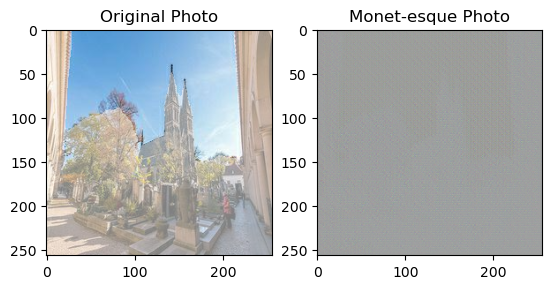

In [20]:
to_monet = monet_generator(example_photo_batch)[0]

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo_batch[0][...,:4] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[...,:4] * 0.5 + 0.5)
plt.show()


In [18]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
        lambda_seg=1,  # Weight for segmentation cycle consistency loss
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.lambda_seg = lambda_seg

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn,
        seg_loss_fn  # Segmentation cycle consistency loss function
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        self.seg_loss_fn = seg_loss_fn  # Segmentation cycle consistency loss

    def train_step(self, batch_data):
        # Unpack the data
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Segmentation cycle consistency loss
            seg_loss_photo = self.seg_loss_fn(real_photo[..., 3:], cycled_photo[..., 3:])
            seg_loss_monet = self.seg_loss_fn(real_monet[..., 3:], cycled_monet[..., 3:])
            total_seg_loss = seg_loss_photo + seg_loss_monet

            # Total generator loss including segmentation loss
            total_monet_gen_loss += total_seg_loss * self.lambda_seg
            total_photo_gen_loss += total_seg_loss * self.lambda_seg

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)


        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss,
            "seg_loss": total_seg_loss,
        }



In [19]:
def discriminator_loss(real, generated):
    # Extract RGB channels
    real_rgb = real[..., :3]
    generated_rgb = generated[..., :3]

    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(
        tf.ones_like(real_rgb), real_rgb)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(
        tf.zeros_like(generated_rgb), generated_rgb)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    generated_rgb = generated[..., :3]
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(
        tf.ones_like(generated_rgb), generated_rgb)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    real_image_rgb = real_image[..., :3]
    cycled_image_rgb = cycled_image[..., :3]
    loss1 = tf.reduce_mean(tf.abs(real_image_rgb - cycled_image_rgb))
    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    real_image_rgb = real_image[..., :3]
    same_image_rgb = same_image[..., :3]
    loss = tf.reduce_mean(tf.abs(real_image_rgb - same_image_rgb))
    return LAMBDA * 0.5 * loss

# Minimized Dice loss for segmentation maps
def minimized_dice_loss(real_image, generated_image, smooth=1e-6):
    # Flatten the tensor to compute the Dice coefficient
    y_true_f = tf.reshape(real_image, [-1])
    y_pred_f = tf.reshape(generated_image, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice_coefficient = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

    # We subtract the Dice coefficient from 1 to create a loss that needs to be minimized
    return 1 - dice_coefficient


In [20]:
monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [21]:
cycle_gan_model = CycleGan(
    monet_generator, photo_generator,
    monet_discriminator, photo_discriminator,
    lambda_cycle=10,  # This weight might need tuning
    lambda_seg=3     # This weight might need tuning
)

cycle_gan_model.compile(
    m_gen_optimizer=monet_generator_optimizer,
    p_gen_optimizer=photo_generator_optimizer,
    m_disc_optimizer=monet_discriminator_optimizer,
    p_disc_optimizer=photo_discriminator_optimizer,
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=calc_cycle_loss,
    identity_loss_fn=identity_loss,
    seg_loss_fn=minimized_dice_loss  # Include the segmentation loss function here
)


In [ ]:
cycle_gan_model.fit(
    full_dataset,
    epochs=20,
    steps_per_epoch=(max(len(monet_image_files), len(photo_image_files))//BATCH_SIZE)
)

In [ ]:
cycle_gan_model.save_weights('checkpoint/checkpoint14')

In [ ]:
tmp_monet_generator = Generator() # transforms photos to Monet-esque paintings
tmp_photo_generator = Generator() # transforms Monet paintings to be more like photos

tmp_monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
tmp_photo_discriminator = Discriminator() # differentiates real photos and generated photos

tmp_monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
tmp_photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

tmp_monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
tmp_photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

model_tmp = CycleGan(
    tmp_monet_generator, tmp_photo_generator,
    tmp_monet_discriminator, tmp_photo_discriminator,
    lambda_cycle=10,  # This weight might need tuning
    lambda_seg=1      # This weight might need tuning
)

model_tmp.compile(
    m_gen_optimizer=tmp_monet_generator_optimizer,
    p_gen_optimizer=tmp_photo_generator_optimizer,
    m_disc_optimizer=tmp_monet_discriminator_optimizer,
    p_disc_optimizer=tmp_photo_discriminator_optimizer,
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=calc_cycle_loss,
    identity_loss_fn=identity_loss,
    seg_loss_fn=minimized_dice_loss  # Include the segmentation loss function here
)

model_tmp.load_weights('checkpoints/checkpoint1')

In [ ]:
monet_generator.save_weights('checkpoints/monet_generator_checkpoint')

In [20]:
model_tmp = Generator()
model_tmp.load_weights('checkpoints_ross_2/ross_generator_checkpoint')

In [21]:
model_tmp_1 = Generator()
model_tmp_1.load_weights('checkpoints_photo_2/photo_generator_checkpoint')

In [28]:
# seg_loss = [0.6422, 0.2967, 0.2388, 0.2097, 0.1732, 0.1496, 0.1538, 0.1522, 0.1396, 0.1398, 0.1275, 0.1229, 0.1089, 0.0957, 0.0890]

# plt.plot(np.arange(1,16), seg_loss)
# plt.xlabel('Epoch')
# plt.ylabel('Total Segmentation Loss (Dice)')
# plt.grid()
# plt.show()


In [1]:
monet_gen_loss = [6.3992,3.9179,3.3316,3.0926,2.9231,2.7748,2.7013,2.6571,2.6380,2.5968, 2.5588, 2.5540, 2.4840, 2.5240, 2.5191, 2.5180, 2.5054, 2.4969, 2.5034]
photo_gen_loss  = [6.2435,4.0103,3.3401,3.1087, 2.9252, 2.7682, 2.7038, 2.6455, 2.5950, 2.5421, 2.4608, 2.4577 , 2.4142 , 2.4043, 2.3921, 2.3925, 2.3663, 2.3257, 2.3313]
seg_loss = [1.0063, 0.4716, 0.3024, 0.2403, 0.2032, 0.1746, 0.1626, 0.1484, 0.1426, 0.1322, 0.1254, 0.1212, 0.1101, 0.1099, 0.1062,0.1052, 0.1001, 0.0981, 0.0964]

In [2]:
monet_gen_loss_ = [3.5683, 2.8522, 2.7576, 2.6839, 2.6418, 2.6471, 2.6965, 2.6648, 2.6982, 2.7055, 2.7380, 2.7844]
photo_gen_loss_ = [3.5084, 2.8058, 2.6933, 2.6114, 2.5828, 2.5676, 2.5769, 2.5671, 2.5615, 2.5621, 2.5704, 2.5969]

In [ ]:
import numpy as np

In [5]:
plt.plot(np.arange(1,20), seg_loss)
plt.xlabel('Epoch')
plt.ylabel('Total Segmentation Loss (Dice)')
plt.grid()
plt.show()

NameError: name 'np' is not defined

NameError: name 'np' is not defined

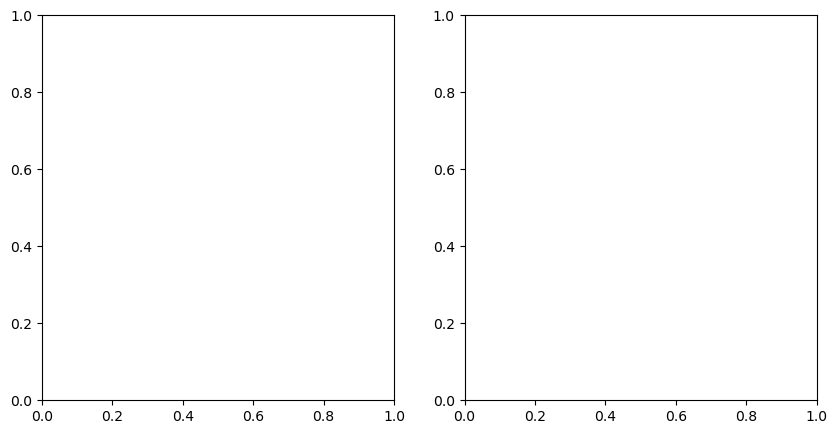

In [6]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))

# plt.subplot(1,2,1)
ax[0].plot(np.arange(1,20), monet_gen_loss, label = 'Our')
ax[0].plot(np.arange(1,13), monet_gen_loss_, label = 'Baseline')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Generator 1')
ax[0].legend()
ax[0].grid()

# plt.subplot(1,2,2)
ax[1].plot(np.arange(1,20), photo_gen_loss, label = 'Our')
ax[1].plot(np.arange(1,13), photo_gen_loss_, label = 'Baseline')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Generator 2')
ax[1].legend()
ax[1].grid()
plt.show()

In [ ]:
monet_gen_loss = [4.3461,2.9270, 2.7097, 2.6199, 2.5305, 2.4902, 2.4700, 2.5199, 2.5208, 2.6041, 2.6055, 2.6243, 2.5942, 2.5501, 2.5541]
photo_gen_loss = [4.6033, 3.0272, 2.7775, 2.6915, 2.5668, 2.5009, 2.4537, 2.4461, 2.4025, 2.4214, 2.3758, 2.3772, 2.3371, 2.2830, 2.2782]
monet_gen_loss_ = [3.2325, 2.5333, 2.3392, 2.2759, 2.2617, 2.2750, 2.2896, 2.3229, 2.3583, 2.3866, 2.4269, 2.4684]
photo_gen_loss_ = [3.3295, 2.6177, 2.4526, 2.4385, 2.4001, 2.4476, 2.4082, 2.3995, 2.3937, 2.3880,  2.3842, 2.3877]

In [ ]:
cycle_gan_model.load_weights('checkpoint/checkpoint14')

In [60]:
#example_monet_batch, example_photo_batch = next(iter(full_dataset))
photo_ds = tf.data.Dataset.from_tensor_slices((photo_image_files, photo_segmentation_files))
photo_ds = photo_ds.map(wrapper_load_and_preprocess(LABELS_PHOTO))
photo_ds = photo_ds.shuffle(buffer_size=500)
photo_ds = photo_ds.batch(4, drop_remainder=True)


In [49]:
photo_ds = tf.data.Dataset.from_tensor_slices((monet_image_files, monet_segmentation_files))
photo_ds = photo_ds.map(wrapper_load_and_preprocess(LABELS_MONET))
photo_ds = photo_ds.shuffle(buffer_size=500)
photo_ds = photo_ds.batch(4, drop_remainder=True)

In [67]:
example_photo = next(iter(photo_ds))
preds = model_tmp.predict(example_photo)


1/1 [==============================] - 0s 110ms/step


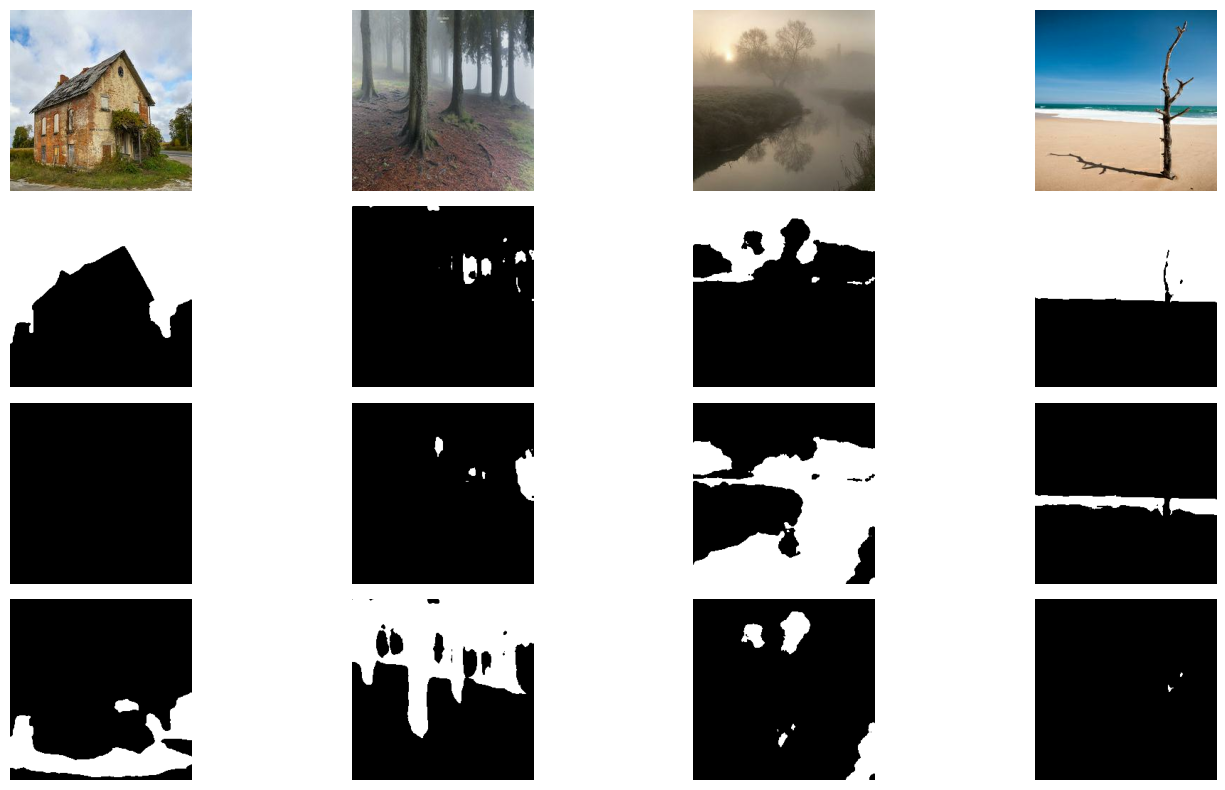

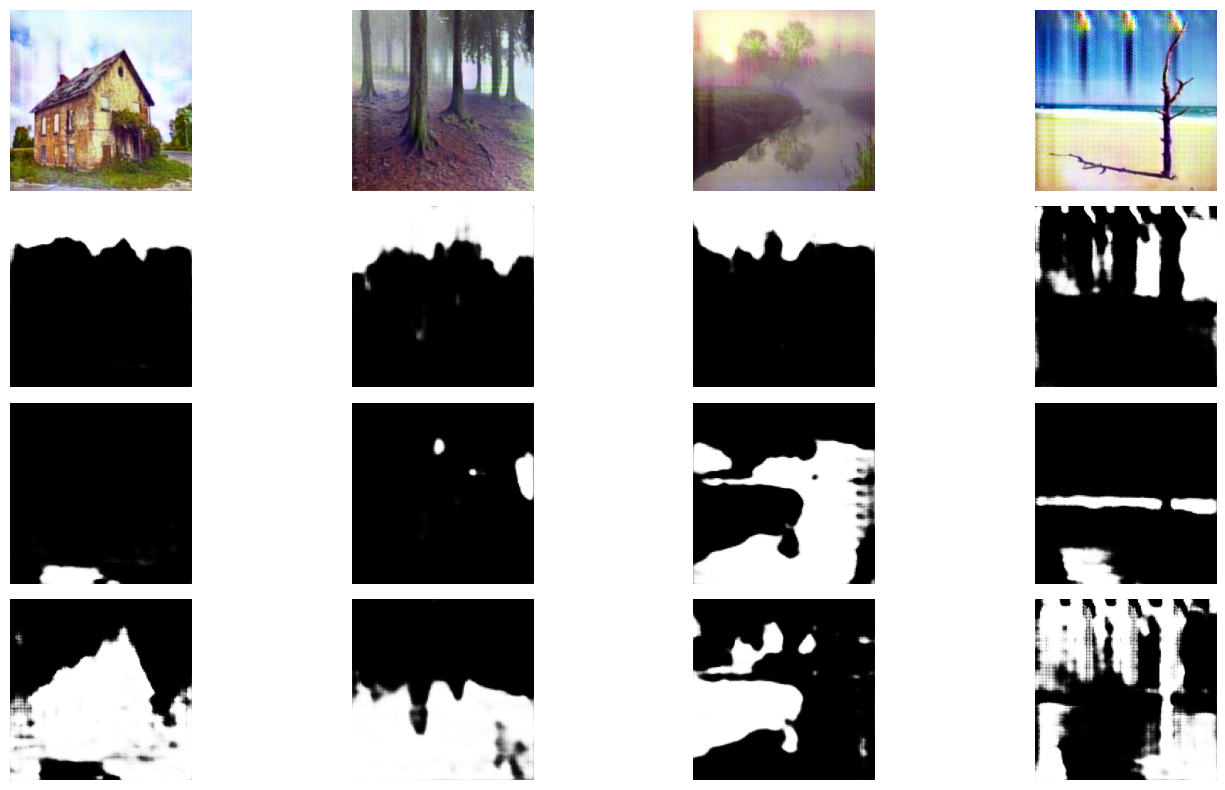

In [68]:
visualize_images_and_masks(example_photo)
print()
visualize_images_and_masks(preds)


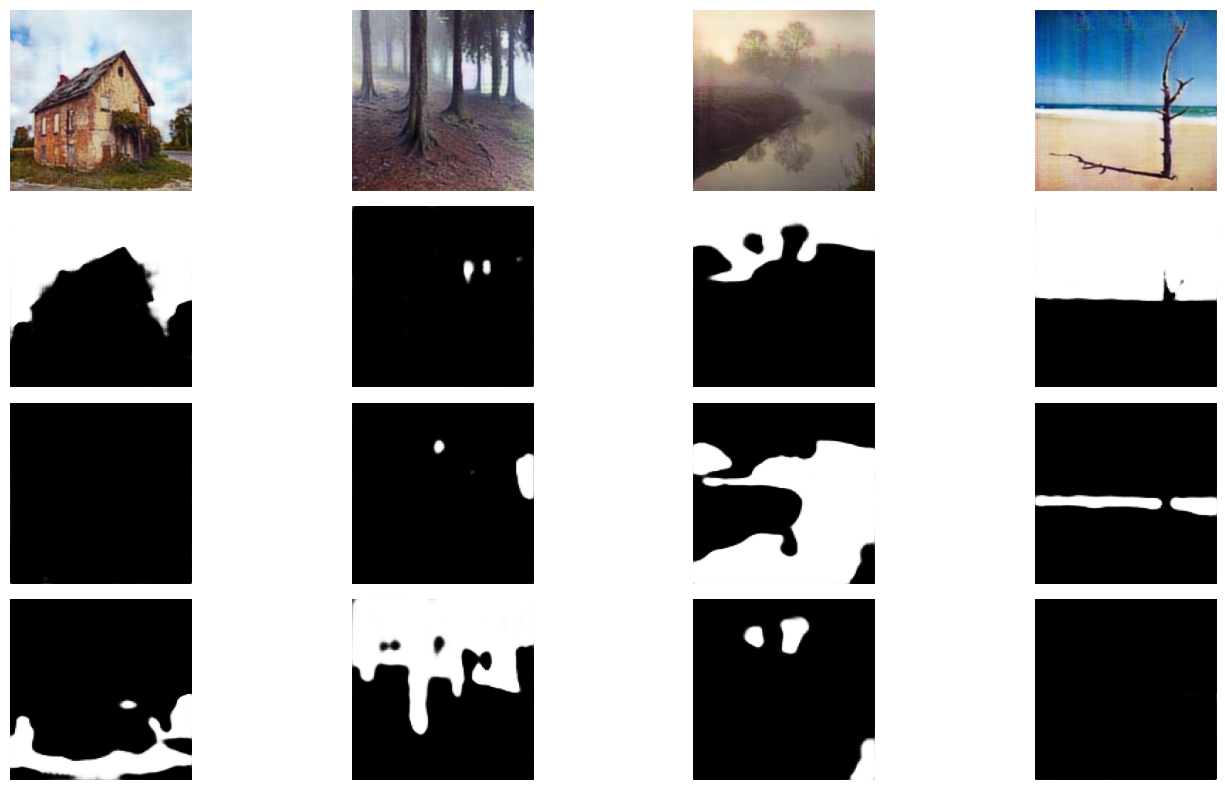

In [69]:
back_photos = model_tmp_1(preds)

visualize_images_and_masks(back_photos)


1/1 [==============================] - 0s 110ms/step


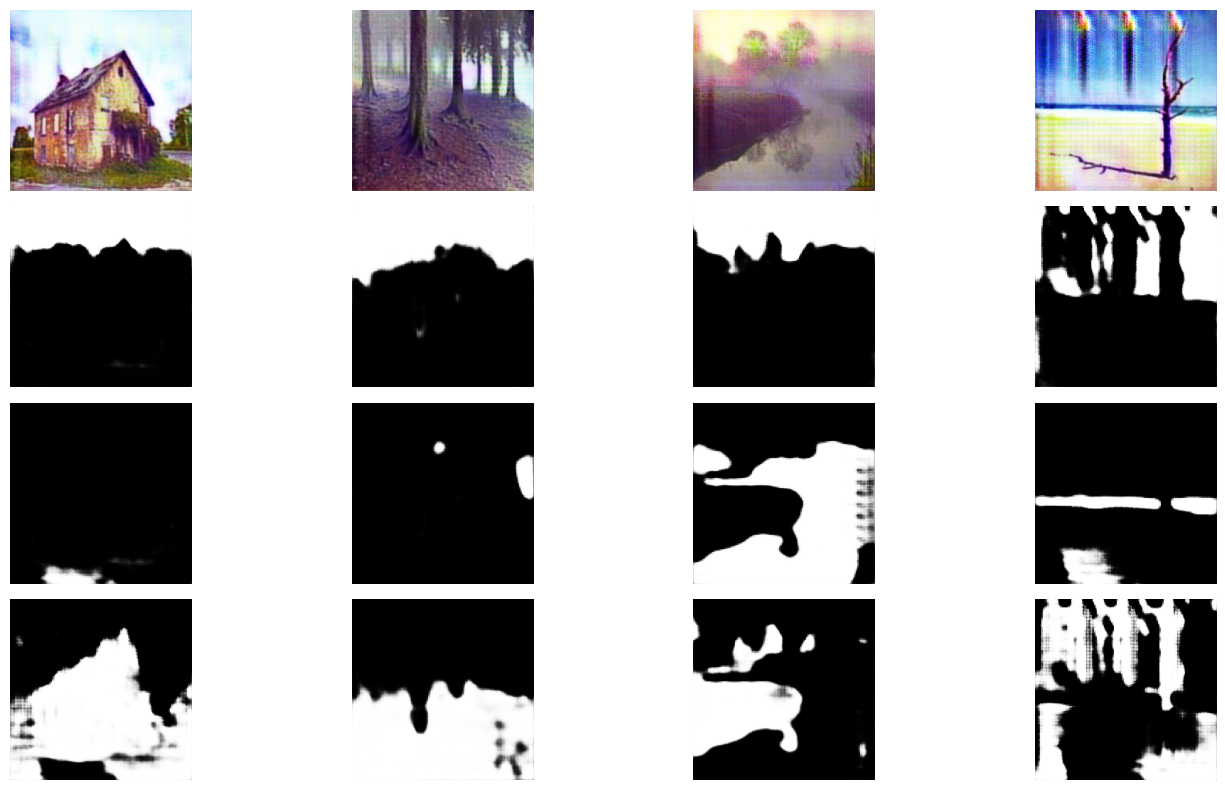

In [70]:
back_photos_preds  = model_tmp.predict(back_photos )
visualize_images_and_masks(back_photos_preds)

In [34]:
import PIL
from tqdm import tqdm

def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in tqdm(input_ds, total=len(photo_image_files)):
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction[...,:3])
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1


In [35]:
photo_ds = tf.data.Dataset.from_tensor_slices((photo_image_files, photo_segmentation_files))
photo_ds = photo_ds.map(wrapper_load_and_preprocess(LABELS_PHOTO))
photo_ds = photo_ds.batch(1)

In [1]:
#os.makedirs('output_images') # Create folder to save generated images

# predict_and_save(photo_ds, monet_generator, 'output_images/')
